In [1]:
import cv2
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from utils import visualize, visualize_multiscale, map_class, parse_model_class_file
from cam_techniques import XGradCAM

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

imgTransform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])


pathImgs = ['/mnt/nas/share/sagar/XAI/val_categorised/590/ILSVRC2012_val_00006215.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/591/ILSVRC2012_val_00006227.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/596/ILSVRC2012_val_00004802.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/667/ILSVRC2012_val_00009855.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/689/ILSVRC2012_val_00019027.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/764/ILSVRC2012_val_00011982.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/887/ILSVRC2012_val_00001805.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/1000/ILSVRC2012_val_00004949.JPEG']

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

vgg = models.vgg16(pretrained=True).eval().to(device)
layer = vgg.features[29]

xgradcamVGG = XGradCAM(vgg, layer)

In [4]:
imagenet_class_file = 'misc/map_clsloc.txt'
model_class_file = 'misc/imagenet1000_clsidx_to_labels.txt'

model_classes = parse_model_class_file(model_class_file)
    
pathImg = pathImgs[0]

model_classid, class_name = map_class(int(pathImg.split('/')[-2]), imagenet_class_file, model_class_file)
print(model_classid, class_name)

795 ski


In [5]:
model_classes.keys()

dict_keys(['ids', 'classnames'])

In [6]:
model_classes['classnames'][model_classid]

'ski'

In [7]:
imgPIL = Image.open(pathImg)
LRimgPIL = transforms.Resize(50)(imgPIL)
img = imgTransform(imgPIL).to(device).unsqueeze(0)
LRimg = imgTransform(LRimgPIL).to(device).unsqueeze(0)

[(-0.5, 499.5, 374.5, -0.5), (-0.5, 65.5, 49.5, -0.5)]

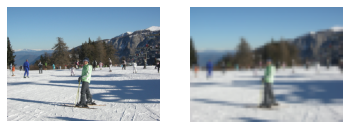

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgPIL)
ax[1].imshow(LRimgPIL)
[x.axis('off') for x in ax.ravel()]

In [9]:
xgradcamMap, logits = xgradcamVGG(img.to(device))
LRxgradcamMap, LRlogits = xgradcamVGG(LRimg.to(device))

if not os.path.exists(os.path.join('outputs', class_name)):
    os.makedirs(os.path.join('outputs',class_name))

save_path = os.path.join('outputs', class_name, 'xgradcam_'+pathImg.split('/')[-1])    

pred = torch.argmax(logits)
LRpred = torch.argmax(LRlogits)
print(pred, LRpred)
print('Predictions. HR: {}, LR: {}'.format(model_classes['classnames'][pred], model_classes['classnames'][LRpred]))

tensor(795, device='cuda:0') tensor(537, device='cuda:0')
Predictions. HR: ski, LR: dogsled


/home/sagar/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True: ski. Predictions. HR: ski, LR: ski


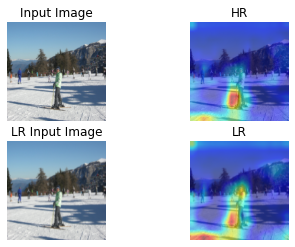

True: candle. Predictions. HR: candle, LR: candle


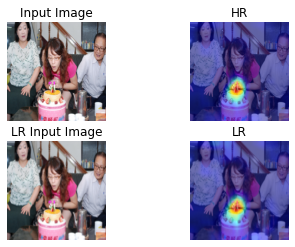

True: pier. Predictions. HR: barn, LR: barn


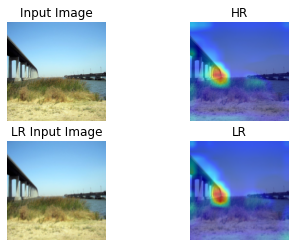

True: dishwasher. Predictions. HR: dishwasher, LR: vacuum


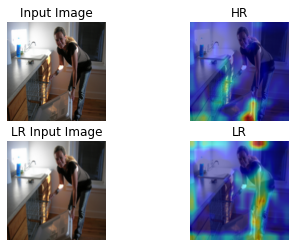

True: boathouse. Predictions. HR: boathouse, LR: boathouse


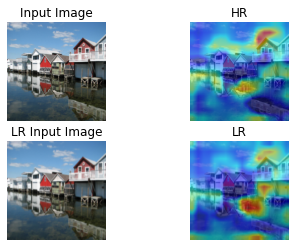

True: modem. Predictions. HR: modem, LR: piggy bank


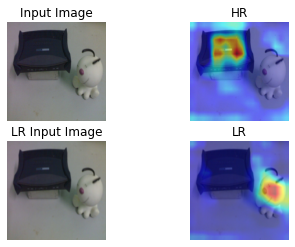

True: bullet train. Predictions. HR: streetcar, LR: bullet train


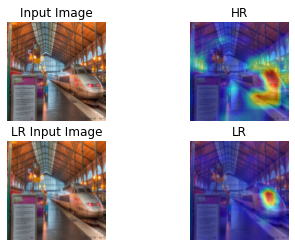

True: dumbbell. Predictions. HR: barbell, LR: dumbbell


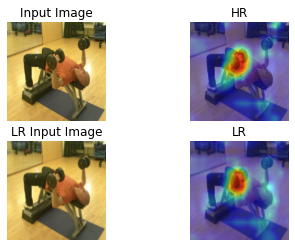

In [10]:
for pathImg in pathImgs:
    model_classid, class_name = map_class(int(pathImg.split('/')[-2]), imagenet_class_file, model_class_file)
    imgPIL = Image.open(pathImg)
    LRimgPIL = transforms.Resize(150)(imgPIL)
    img = imgTransform(imgPIL).to(device).unsqueeze(0)
    LRimg = imgTransform(LRimgPIL).to(device).unsqueeze(0)
    xgradcamMap, logits = xgradcamVGG(img.to(device))
    LRxgradcamMap, LRlogits = xgradcamVGG(LRimg.to(device))

    if not os.path.exists(os.path.join('outputs', class_name)):
        os.makedirs(os.path.join('outputs',class_name))

    save_path = os.path.join('outputs', class_name, 'xgradcam_'+pathImg.split('/')[-1])    
    pred = torch.argmax(logits)
    LRpred = torch.argmax(LRlogits)
    print('True: {}. Predictions. HR: {}, LR: {}'.format(
        class_name,
        model_classes['classnames'][pred], 
        model_classes['classnames'][LRpred]
    ))
    visualize_multiscale(imgPIL, LRimgPIL, xgradcamMap.cpu(), LRxgradcamMap.cpu())
